# **Import Libraries**

In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download NLTK stopwords if you haven't already
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Load Dataset**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/vaccination_tweets.csv')

In [4]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [5]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [6]:
df = df[['text']]

In [7]:
df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [8]:
df.shape

(11020, 1)

In [9]:
df.drop_duplicates(inplace = True)

In [10]:
df.shape

(11013, 1)

In [11]:
df.isnull().sum()

text    0
dtype: int64

# **Data Processing**

**Removing Special Characters, Tokenization, Stopwords and Lowercasing**

In [12]:
def data_processing(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'RT[\s]+', '', text)  # Remove retweets
    text = re.sub(r'https?:\/\/\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'https\S+|www\S+https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = text.lower()

    text_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_text = [w for w in text_tokens if not w in stop_words]

    return ' '.join(filtered_text)

In [13]:
df.text = df['text'].apply(data_processing)

In [14]:
df.shape

(11013, 1)

In [15]:
df = df.drop_duplicates('text')

In [16]:
df.shape

(10481, 1)

**Stemming**

In [17]:
stemmer = PorterStemmer()

In [18]:
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [19]:
df['text'] = df['text'].apply(lambda x: stemming(x))

In [20]:
df.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine whereareallthesickpeople ...


## **Polarity**

In [21]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [22]:
df['polarity'] = df['text'].apply(polarity)

In [23]:
df.head()

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.0
1,world wrong side history year hopefully bigges...,-0.5
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0
3,facts immutable senator even youre ethically s...,0.1
4,explain need vaccine whereareallthesickpeople ...,0.0


# **Sentiments**

In [24]:
def sentiment(label):
    if label < 0:
        return 'Negative'
    elif label > 0:
        return 'Positve'
    elif label == 0:
        return 'Neutral'

In [25]:
df['sentiment'] = df['polarity'].apply(sentiment)

In [26]:
df.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,facts immutable senator even youre ethically s...,0.1,Positve
4,explain need vaccine whereareallthesickpeople ...,0.0,Neutral


# **Visualize Sentiment Distribution**

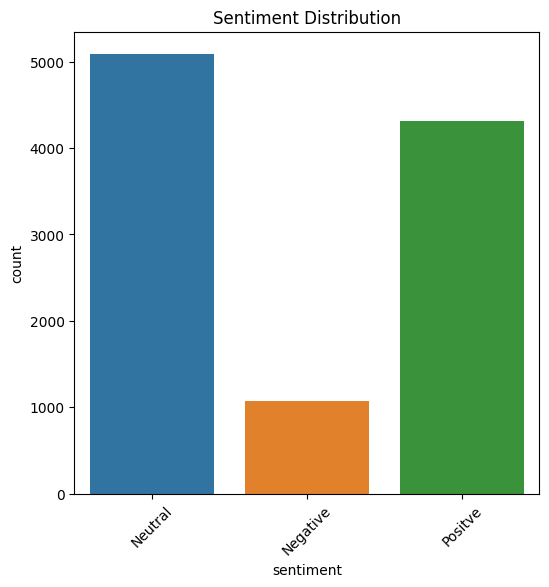

In [27]:
sentiment_counts = df['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 6))
sns.countplot(x='sentiment', data = df)
plt.title('Sentiment Distribution')
plt.xticks(rotation=45)
plt.show()

# **Visualize Pie Graph**

Text(0.5, 1.0, 'Sentiment Distribution')

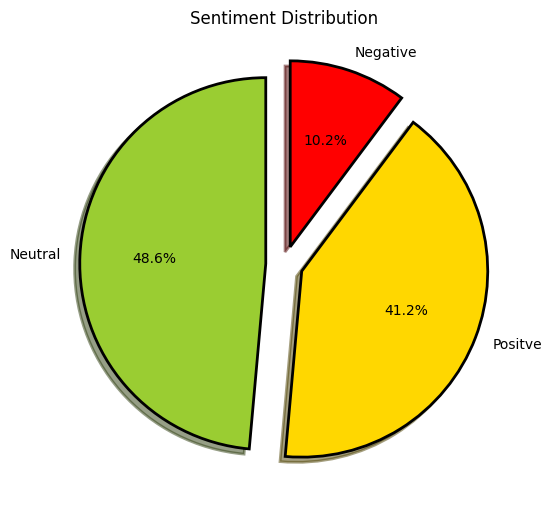

In [28]:
fig = plt.figure(figsize=(6,7))
colors = ('yellowgreen', 'gold', 'red')
wp = {'linewidth': 2, 'edgecolor': 'black'}
tags = df['sentiment'].value_counts()
explode = (0.1, 0.1, 0.1)
tags.plot(kind = 'pie', autopct = '%1.1f%%', shadow = True, colors = colors, startangle = 90,
          wedgeprops = wp, explode = explode, label = '')
plt.title("Sentiment Distribution")

# **Create a word cloud of the entire text**

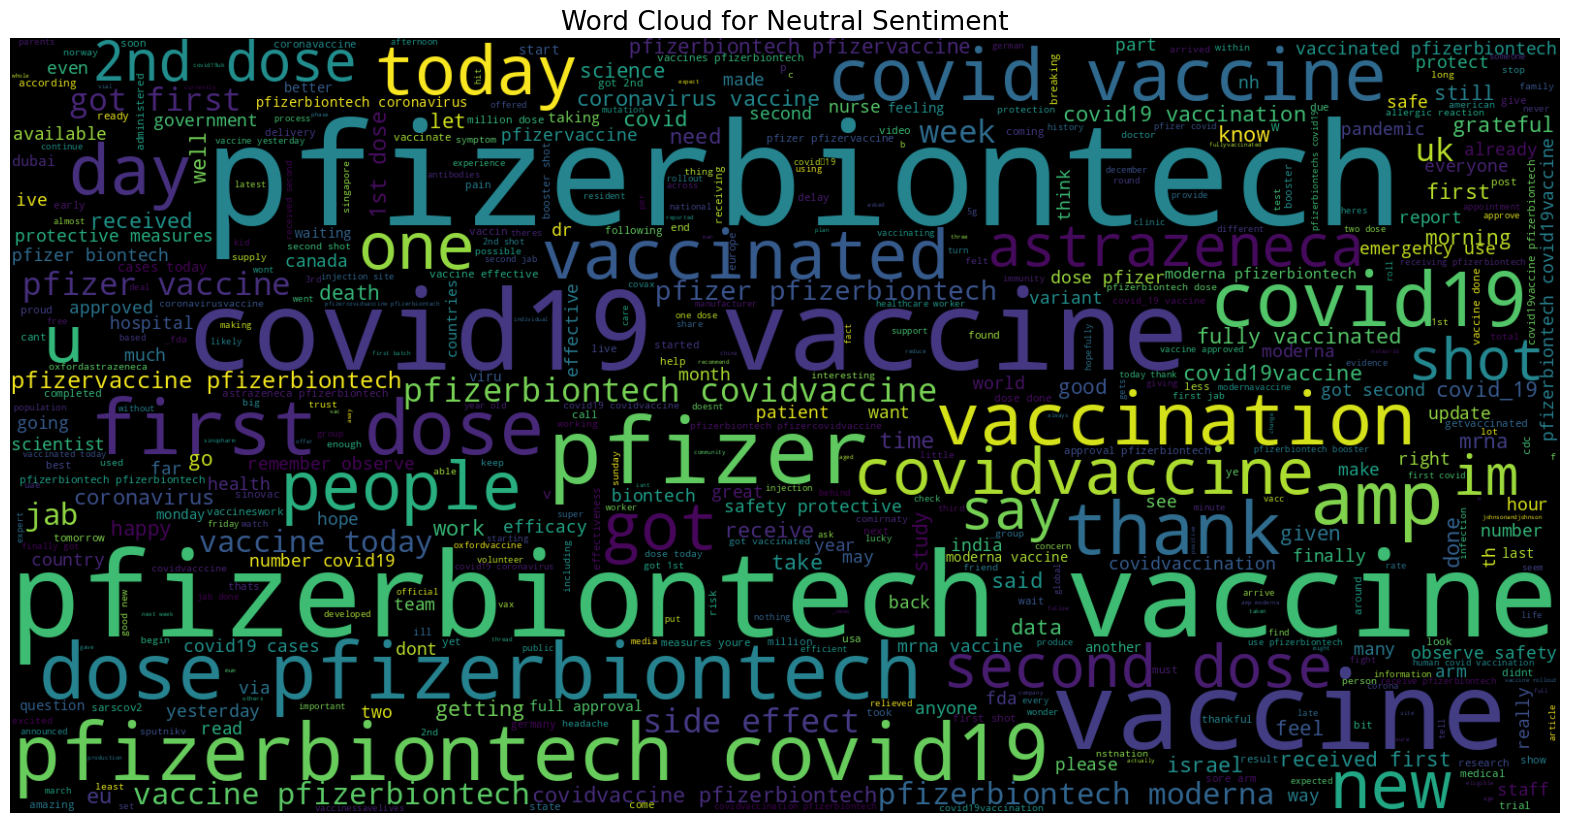

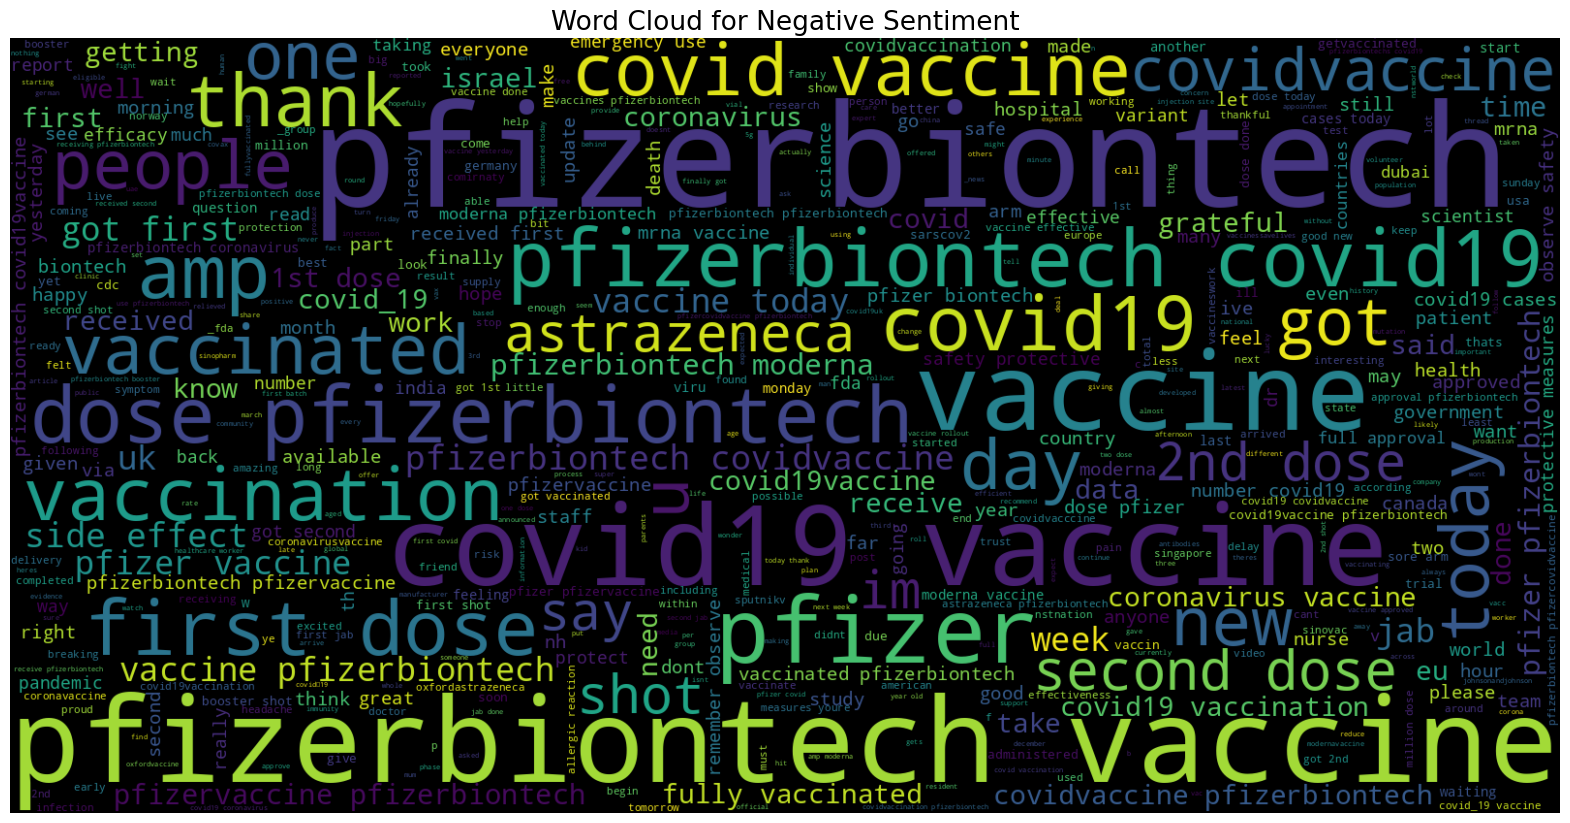

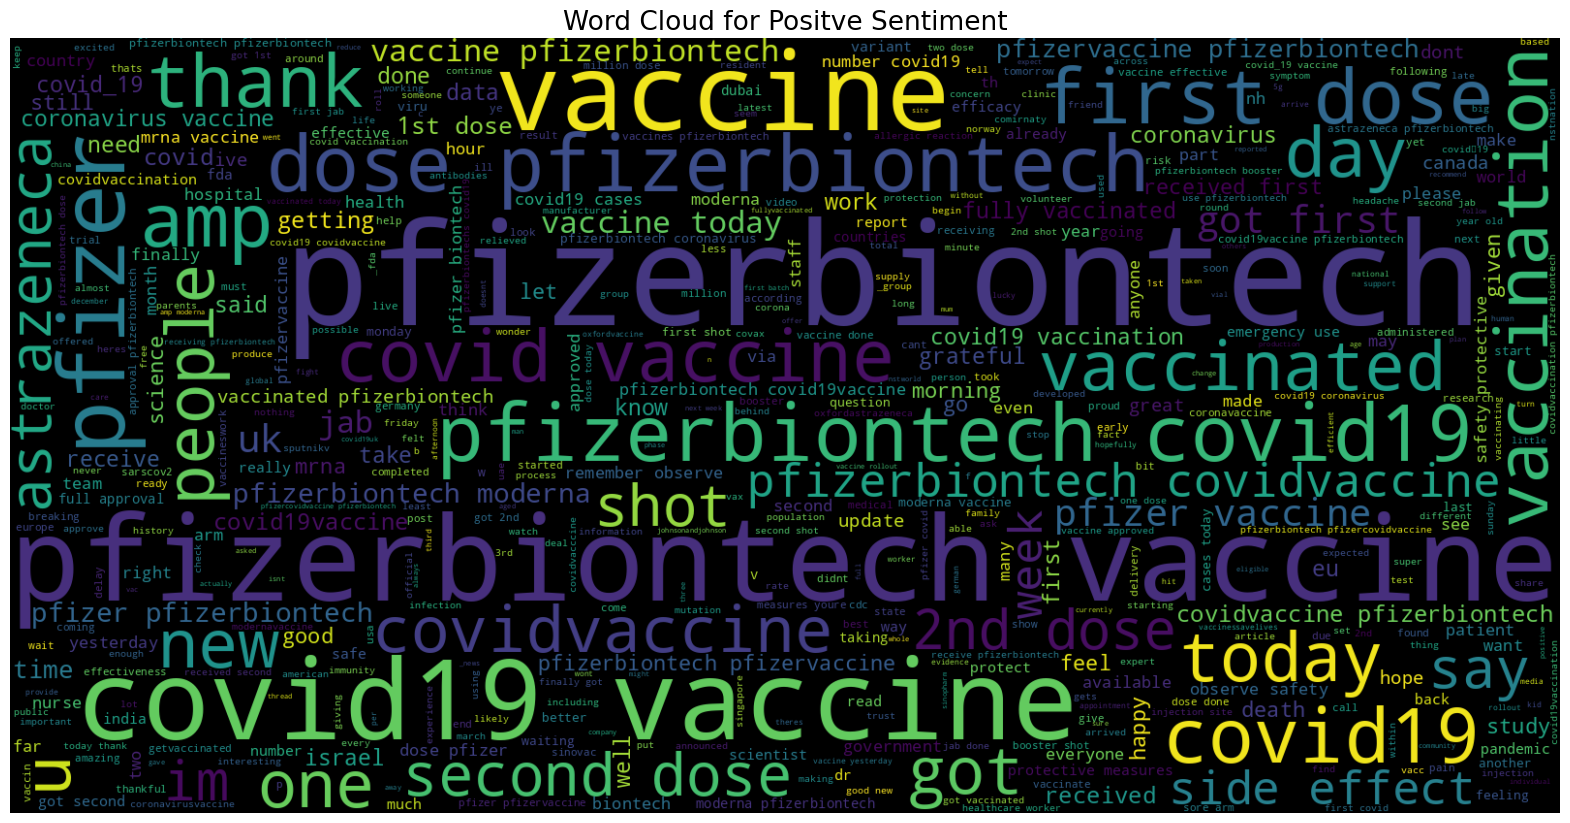

In [29]:
sentiments = df['sentiment'].unique()

for sentiment in sentiments:
    text = ' '.join(df['text'])
    plt.figure(figsize=(20, 15), facecolor = None)
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment', fontsize=19)
    plt.axis('off')
    plt.show()

# **Visualize Text Length Distribution by Sentiment**

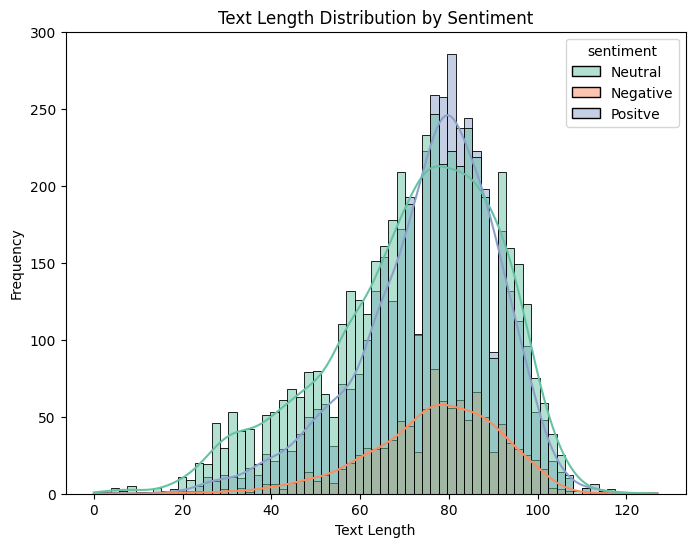

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x=df['text'].str.len(), hue='sentiment', kde=True, palette='Set2')
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# **Word frequency analysis**

In [31]:
word_freq = Counter(text.split())
common_words = word_freq.most_common(20)  # Get the 20 most common words
print('Top 20 Most Common Words:')
for word, freq in common_words:
    print(f'{word}: {freq}')

Top 20 Most Common Words:
pfizerbiontech: 6005
vaccine: 4101
covid19: 2306
dose: 1433
pfizer: 1301
first: 1161
today: 798
got: 784
vaccines: 735
vaccinated: 728
covidvaccine: 701
covid: 697
vaccination: 590
get: 557
second: 550
amp: 473
pfizervaccine: 461
moderna: 442
2nd: 432
people: 431


# **Number of Unique classes**

In [32]:
num_classes = 3

# **Split the dataset into training and testing**

In [33]:
X = df['text']
y = df['sentiment']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Tokenization and padding**



In [35]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [36]:
# Pad sequences to a fixed length
max_sequence_length = 100  # You can adjust this based on your dataset
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_sequence_length)

# **List of RNN models**

In [38]:
rnn_models = [
    ('LSTM', LSTM),
    ('GRU', GRU),
    ('SimpleRNN', SimpleRNN)
]

# **Train and Evaluate the models**

In [41]:
from sklearn.preprocessing import LabelEncoder

# Initialize a label encoder
label_encoder = LabelEncoder()

Training and Evaluating LSTM model...
Epoch 1/5
131/131 [==============================] - 41s 294ms/step - loss: 0.7691 - accuracy: 0.6444 - val_loss: 0.4978 - val_accuracy: 0.8174
Epoch 2/5
131/131 [==============================] - 29s 223ms/step - loss: 0.2354 - accuracy: 0.9213 - val_loss: 0.3487 - val_accuracy: 0.8898
Epoch 3/5
131/131 [==============================] - 28s 215ms/step - loss: 0.0570 - accuracy: 0.9845 - val_loss: 0.3816 - val_accuracy: 0.8941
Epoch 4/5
131/131 [==============================] - 28s 212ms/step - loss: 0.0199 - accuracy: 0.9955 - val_loss: 0.4495 - val_accuracy: 0.9003
Epoch 5/5
66/66 [==============================] - 2s 29ms/step - loss: 0.4885 - accuracy: 0.8927
LSTM Test loss: 48.85%
LSTM Test accuracy: 89.27%
LSTM Model Save


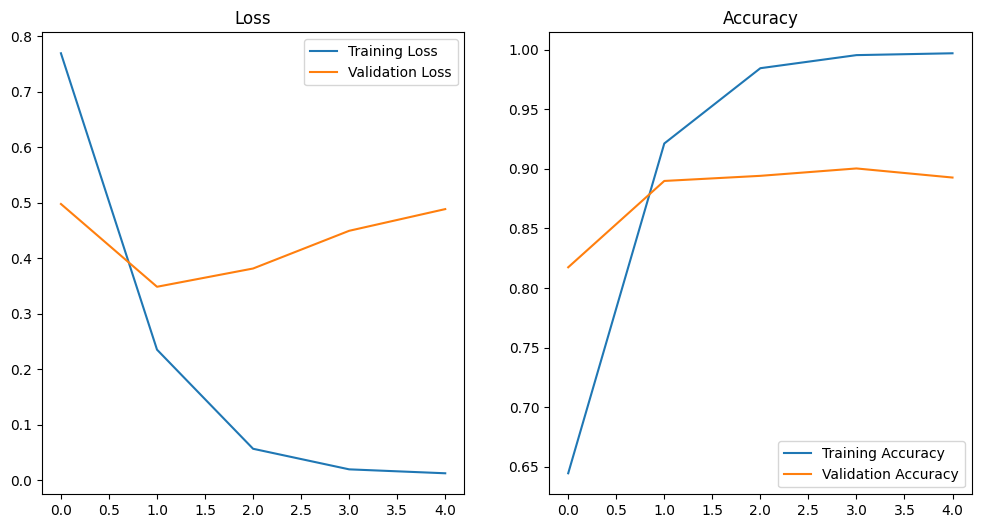


Training and Evaluating GRU model...
Epoch 1/5
131/131 [==============================] - 39s 273ms/step - loss: 0.7173 - accuracy: 0.6760 - val_loss: 0.4411 - val_accuracy: 0.8464
Epoch 2/5
131/131 [==============================] - 29s 218ms/step - loss: 0.2030 - accuracy: 0.9339 - val_loss: 0.2758 - val_accuracy: 0.9165
Epoch 3/5
131/131 [==============================] - 27s 204ms/step - loss: 0.0506 - accuracy: 0.9863 - val_loss: 0.2997 - val_accuracy: 0.9194
Epoch 4/5
131/131 [==============================] - 26s 199ms/step - loss: 0.0195 - accuracy: 0.9950 - val_loss: 0.3166 - val_accuracy: 0.9213
Epoch 5/5
66/66 [==============================] - 2s 27ms/step - loss: 0.3861 - accuracy: 0.9103
GRU Test loss: 38.61%
GRU Test accuracy: 91.03%
GRU Model Save


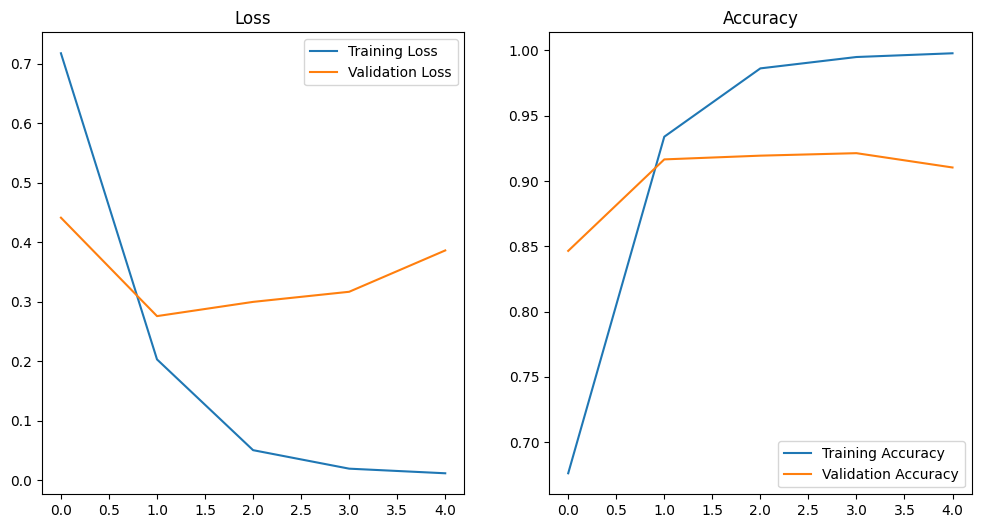


Training and Evaluating SimpleRNN model...
Epoch 1/5
131/131 [==============================] - 27s 186ms/step - loss: 0.9919 - accuracy: 0.4665 - val_loss: 0.9262 - val_accuracy: 0.5842
Epoch 2/5
131/131 [==============================] - 16s 121ms/step - loss: 0.7555 - accuracy: 0.6794 - val_loss: 0.5844 - val_accuracy: 0.7763
Epoch 3/5
131/131 [==============================] - 14s 111ms/step - loss: 0.3660 - accuracy: 0.8720 - val_loss: 0.5507 - val_accuracy: 0.8011
Epoch 4/5
131/131 [==============================] - 14s 109ms/step - loss: 0.2235 - accuracy: 0.9225 - val_loss: 0.6820 - val_accuracy: 0.8021
Epoch 5/5
66/66 [==============================] - 1s 10ms/step - loss: 0.4527 - accuracy: 0.8417
SimpleRNN Test loss: 45.27%
SimpleRNN Test accuracy: 84.17%
SimpleRNN Model Save


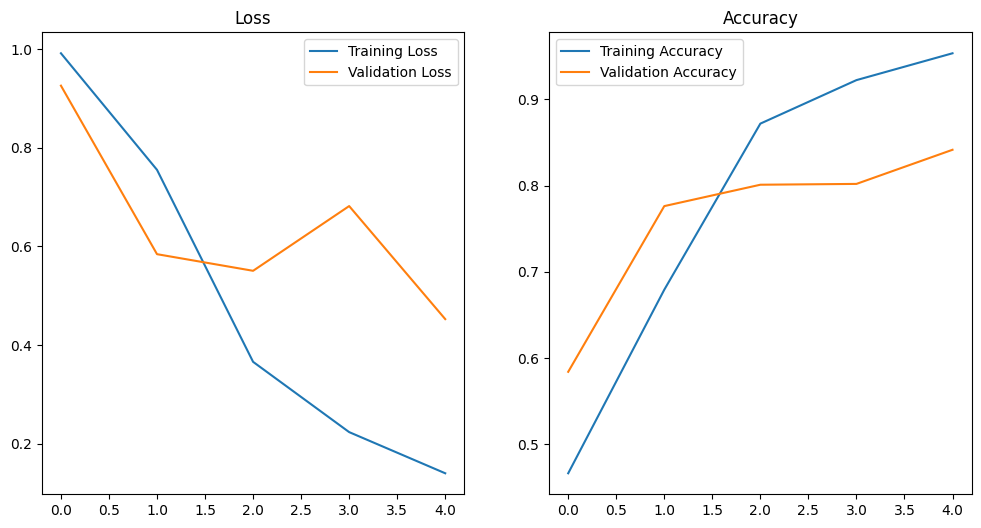

In [44]:
for rnn_name, rnn_layer in rnn_models:
  print(f"Training and Evaluating {rnn_name} model...")

  # Build the RNN model
  model = Sequential()
  model.add(Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 128, input_length = max_sequence_length))
  model.add(rnn_layer(256, dropout = 0.2, recurrent_dropout = 0.2))
  model.add(Dense(num_classes, activation = 'softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Encode the string labels into integer labels
  y_train_encoded = label_encoder.fit_transform(y_train)
  y_test_encoded = label_encoder.transform(y_test)

  # One-hot encode the integer labels
  y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
  y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

  # Train the model
  history = model.fit(X_train_pad, y_train_one_hot, validation_data=(X_test_pad, y_test_one_hot), epochs=5, batch_size=64)


  # Evaluate the model
  loss, accuracy = model.evaluate(X_test_pad, y_test_one_hot)
  print(f'{rnn_name} Test loss: {loss * 100:.2f}%')
  print(f'{rnn_name} Test accuracy: {accuracy * 100:.2f}%')

  # Save the model
  model.save(f"sentiment_analysis_model_{rnn_name}.h5")
  print(f"{rnn_name} Model Save")

  # Plot training history
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.legend()
  plt.show()

  print()